In [0]:
import pandas as pd
import gc
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import Imputer
import numpy as np
import pandas as pd

class MiceImputer:
    
    model_dict_ = {}
    
    def __init__(self, seed_nulls=False, seed_strategy='mean'):
        self.seed_nulls = seed_nulls
        self.seed_strategy = seed_strategy
        
    
    def transform(self, X):
        col_order = X.columns
        new_X = []
        mutate_cols = list(self.model_dict_.keys())
        
        for i in mutate_cols:
            y = X[i]
            x_null = X[y.isnull()]
            y_null = y[y.isnull()].reset_index()['index']
            y_notnull = y[y.notnull()]
            
            model = self.model_dict_.get(i)
            
            if self.seed_nulls:
                x_null = model[1].transform(x_null)
            else:
                null_check = x_null.isnull().any()
                x_null = x_null[null_check.index[~null_check]]
            
            pred = pd.concat([pd.Series(model[0].predict(x_null))\
                              .to_frame()\
                              .set_index(y_null),y_notnull], axis=0)\
                              .rename(columns={0: i})
            
            new_X.append(pred)

        new_X.append(X[X.columns.difference(mutate_cols)])

        final = pd.concat(new_X, axis=1)[col_order]

        return final
        
        
    def fit(self, X):      
        x = X.fillna(value=np.nan)

        null_check = x.isnull().any()
        null_data = x[null_check.index[null_check]]
        
        for i in null_data:
            y = null_data[i]
            y_notnull = y[y.notnull()]

            model_list = []
            if self.seed_nulls:
                imp = Imputer(strategy=self.seed_strategy)
                model_list.append(imp.fit(x))
                non_null_data = pd.DataFrame(imp.fit_transform(x))
                
            else:
                non_null_data = x[null_check.index[~null_check]]
                
            
            x_notnull = non_null_data[y.notnull()]
            
            if y.nunique() > 2:
                model = LinearRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})
            else:
                model = LogisticRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})

        return self
        

    def fit_transform(self, X):
        return self.fit(X).transform(X)


In [0]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
weather_train = pd.read_csv('/content/drive/My Drive/weather_train1.csv')
build_metadata = pd.read_csv('/content/drive/My Drive/building_metadata1.csv')


In [0]:
print(train.shape)
print(build_metadata.shape)
print(weather_train.shape)


In [0]:
#weather_train.drop(['cloud_coverage','precip_depth_1_hr','wind_direction'],axis=1,inplace = True)
print(weather_train.isnull().sum())
print(build_metadata.isnull().sum())
#build_metadata.drop(['year_built','floor_count'],axis = 1,inplace = True)

In [0]:
train_data = train.merge(build_metadata, on="building_id", how="left")

In [0]:
train_data = train_data.merge(weather_train, on=["site_id","timestamp"])


In [0]:
train_data.isnull().sum()

In [0]:
#Uncomment if any missing values are to be imputed
#mi = MiceImputer()
#train_data = mi.fit_transform(train_data)

In [0]:
#train_data.isnull().sum()

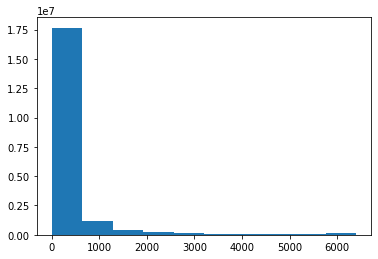

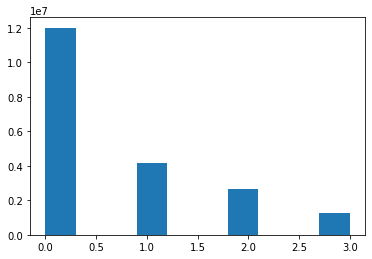

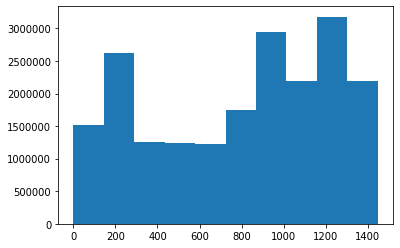

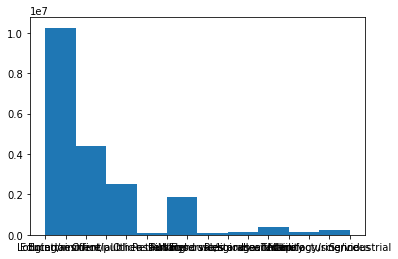

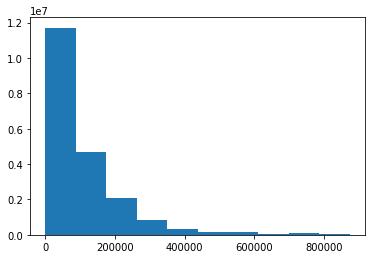

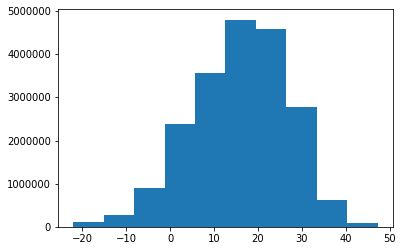

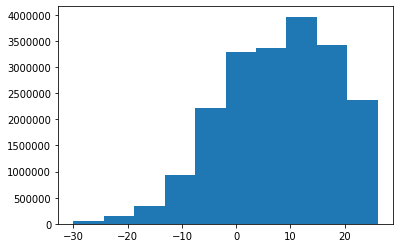

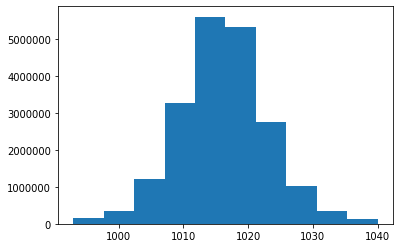

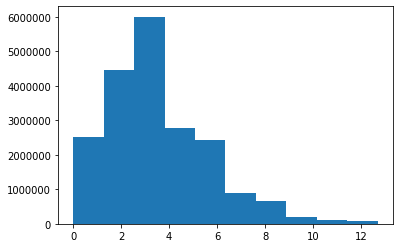

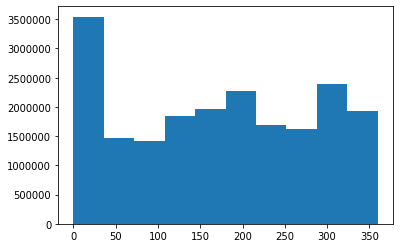

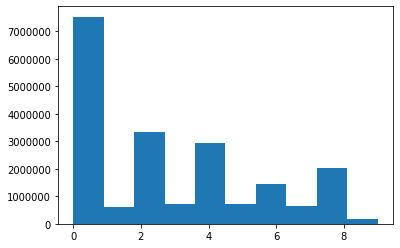

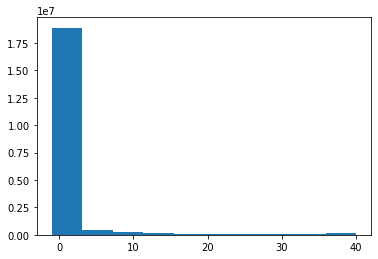

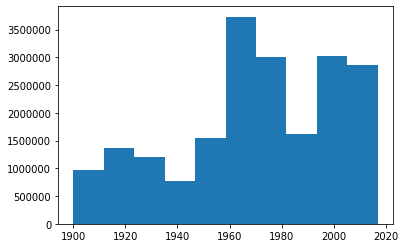

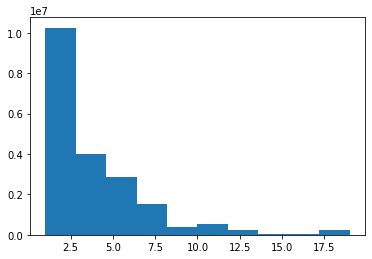

In [8]:
# Removing the outliers
train_data.loc[train_data['meter_reading']>6400,'meter_reading'] = 6400
train_data.loc[train_data['air_temperature']<-22,'air_temperature']=-22
train_data.loc[train_data['air_temperature']>48,'air_temperature']=48
train_data.loc[train_data['dew_temperature']<-30,'dew_temperature']=-30
train_data.loc[train_data['sea_level_pressure']<993,'sea_level_pressure']=993
train_data.loc[train_data['sea_level_pressure']>1040,'sea_level_pressure']=1040
train_data.loc[train_data['wind_speed']>12.7,'wind_speed']=12.7
#train_data.loc[train_data['square_feet']>800000,'square_feet']=800000
train_data.loc[train_data['precip_depth_1_hr']>40,'precip_depth_1_hr'] = 40
train_data.loc[train_data['floor_count']>19,'floor_count']=19

plt.hist(train_data['meter_reading'])
plt.show()                             
plt.hist(train_data['meter'])
plt.show()
plt.hist(train_data['building_id'])
plt.show()
plt.hist(train_data['primary_use'])
plt.show()
plt.hist(train_data['square_feet'])
plt.show()
plt.hist(train_data['air_temperature'])
plt.show()
plt.hist(train_data['dew_temperature'])
plt.show()
plt.hist(train_data['sea_level_pressure'])
plt.show()
plt.hist(train_data['wind_speed'])
plt.show()
plt.hist(train_data['wind_direction'])
plt.show()
plt.hist(train_data['cloud_coverage'])
plt.show()
plt.hist(train_data['precip_depth_1_hr'])
plt.show()
plt.hist(train_data['year_built'])
plt.show()
plt.hist(train_data['floor_count'])
plt.show()


In [9]:

del train
# deleting so as to prevent session crash due to RAM overflow
del build_metadata
del weather_train
gc.collect()

6079

In [0]:
#train_data['square_feet'] = np.log(train_data['square_feet'])


In [0]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
train_data.timestamp = pd.to_datetime(train_data.timestamp, format="%Y-%m-%d %H:%M:%S")
  
train_data["hour"] = train_data.timestamp.dt.hour
train_data["month"]= train_data.timestamp.dt.month
train_data["weekday"] = train_data.timestamp.dt.weekday
train_data["is_holiday"] = (train_data.timestamp.isin(holidays)).astype(int)


In [0]:
train_data.drop(['timestamp'],axis=1,inplace = True)

In [0]:
train_data.shape

In [0]:
train_data.isnull().sum()

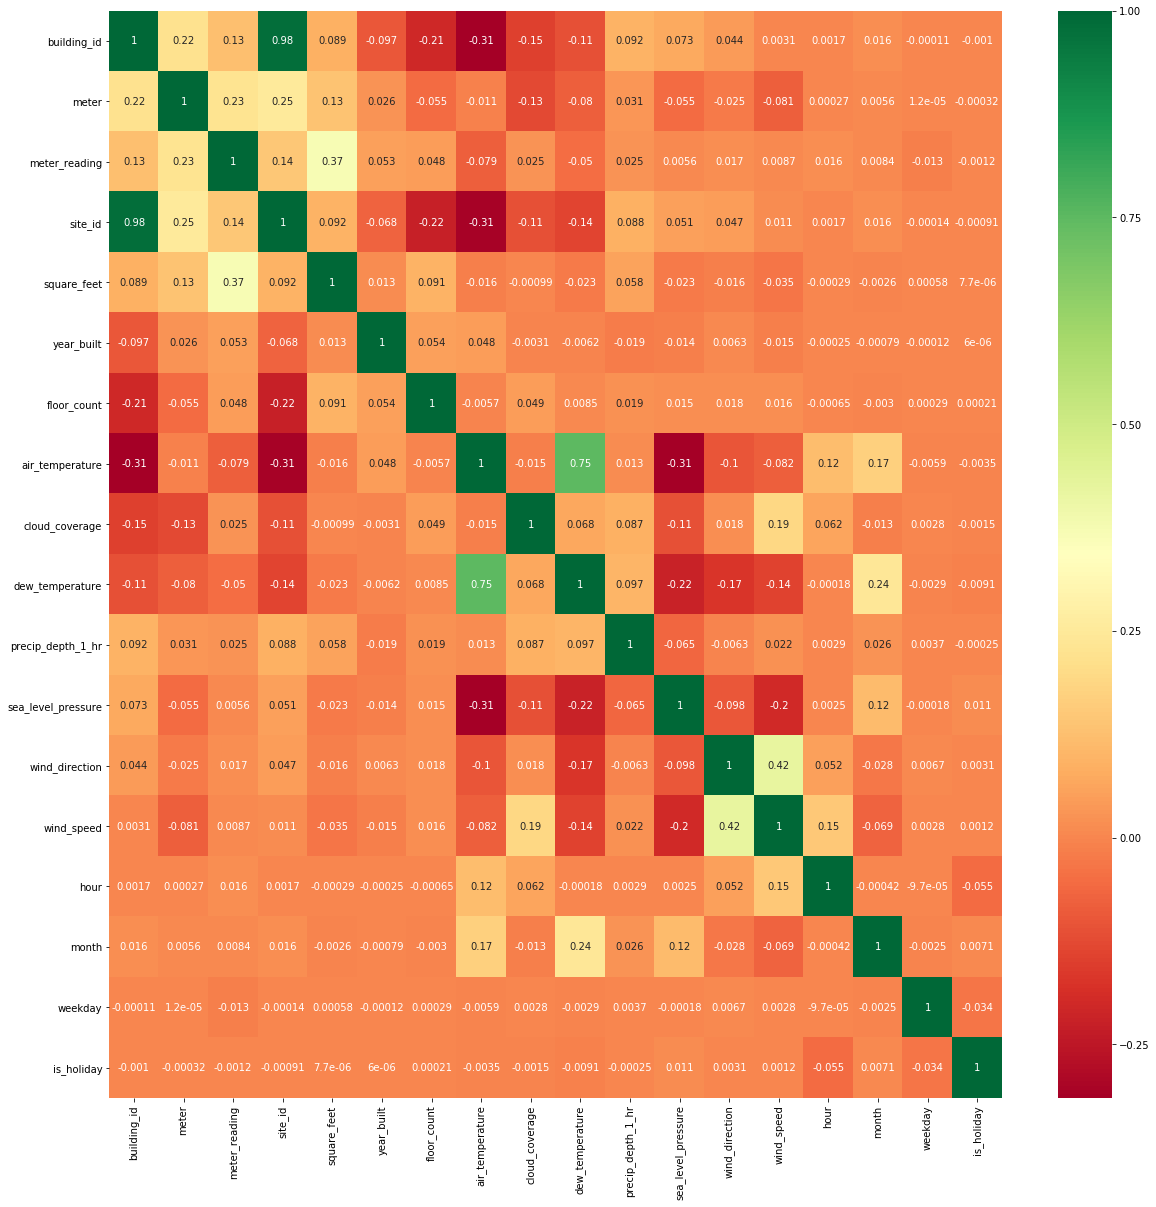

In [0]:
correlation = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,cmap = 'RdYlGn')

In [0]:
train_data.head()

In [0]:
p1 = train_data['building_id']*train_data['meter']
p2 = train_data['square_feet']/train_data['sea_level_pressure']
p3 = train_data['air_temperature']+train_data['dew_temperature']
p5 = train_data['site_id']
p6 = train_data['meter_reading']

In [13]:
df = pd.concat([p1,p2,p3,p5,p6,train_data['meter_reading']],axis = 1)
del p1,p2,p3,p5,p6
gc.collect()

39

In [0]:
df = df.iloc[:,:-1]
#df.head(10)

In [0]:
pf = train_data#[train_data['site_id']==1]
tf = df#[df['site_id']==1]
#correlation = tf.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(correlation,annot=True)

In [0]:
#tf.drop(['site_id'],axis=1,inplace = True)

pf.drop(['site_id','meter_reading'],axis=1,inplace = True)
pf = pd.concat([pf,tf],axis = 1)

In [0]:
#pf.drop(['year_built'],axis=1,inplace = True)
#pf.head(5)

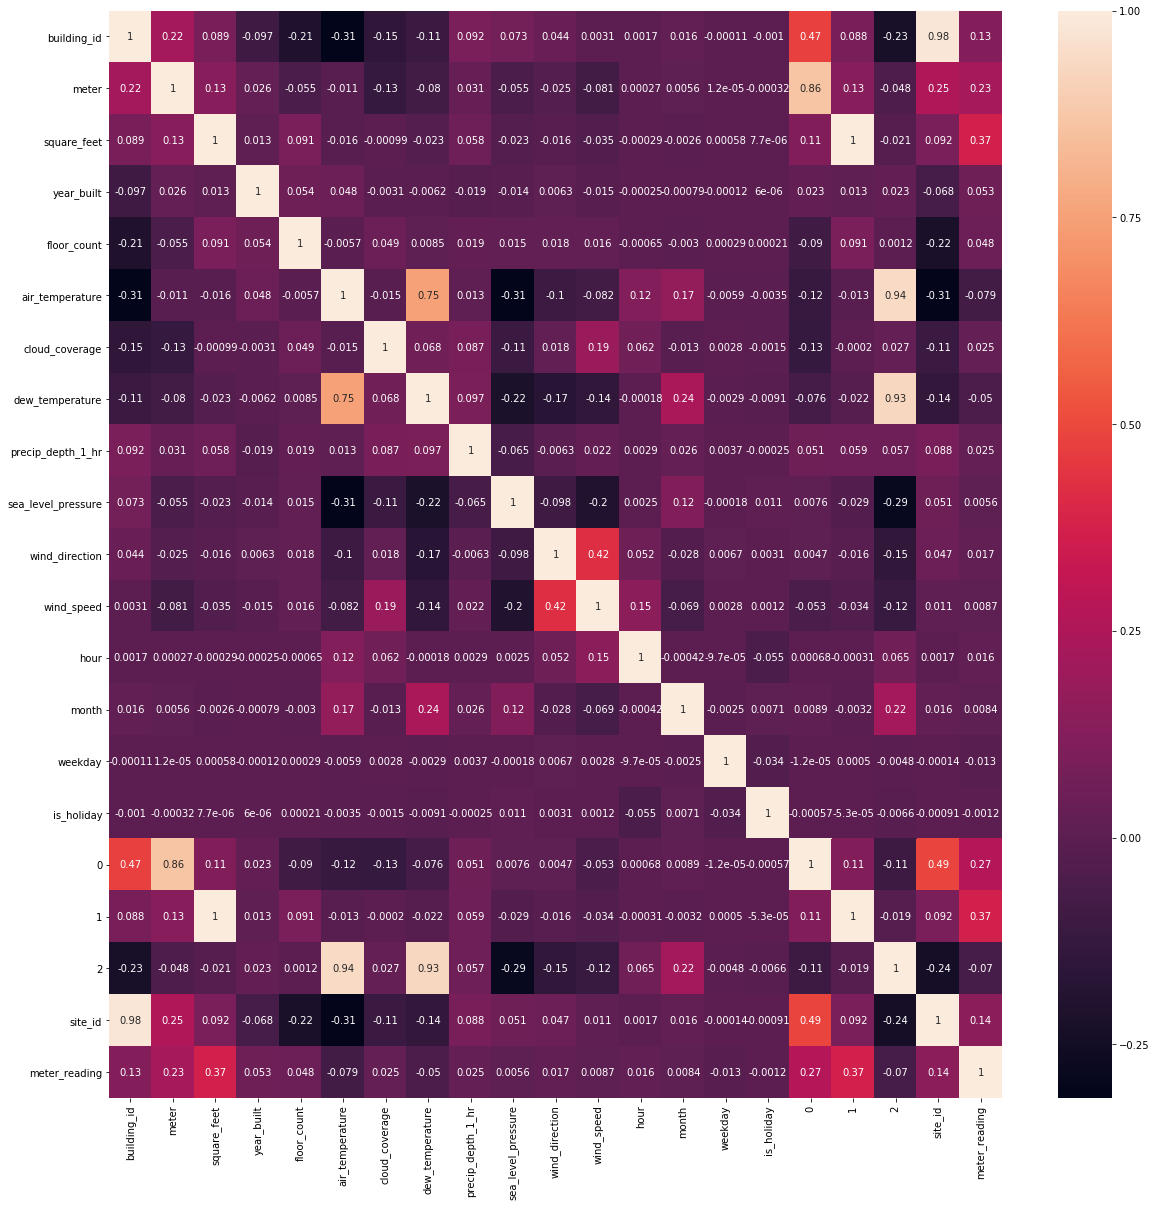

In [17]:
correlation = pf.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True)

In [0]:
le = LabelEncoder()
pf['primary_use'] = le.fit_transform(pf['primary_use'])


In [0]:
X = pf.iloc[:,:-1]
y = pf.iloc[:,-1]
#X.head()


In [0]:
y.head()

In [0]:
print( str(X.shape[0]) + '  ' + str(y.shape[0]))

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42)

In [0]:
X_train.head()

In [0]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [0]:


sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)




In [0]:
sc_Y = StandardScaler()
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train = sc_Y.fit_transform(y_train)
y_test = sc_Y.fit_transform(y_test)
y_train = y_train[:,0]
y_test = y_test[:,0]

In [0]:
#Using Artificial Neural Networks   # Not working well on this dataset

import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
regressor = Sequential()

# Adding the input layer and the first hidden layer
regressor.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu', input_dim = 21))

# Adding the second hidden layer
regressor.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu'))
regressor.add(Dense(output_dim = 15, init = 'uniform', activation = 'relu'))
regressor.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu'))
regressor.add(Dense(output_dim = 12, init = 'uniform', activation = 'relu'))

# Adding the output layer
regressor.add(Dense(output_dim = 1, init = 'uniform', activation = 'relu'))

# Compiling the ANN
regressor.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

# Fitting the ANN to the Training set
regressor.fit(X_train, y_train, batch_size = 512, nb_epoch = 100,validation_data = (X_test,y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=21, units=18, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=18, kernel_initializer="uniform")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=18, kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the 

Train on 17106764 samples, validate on 3018841 samples
Epoch 1/100
12427776/17106764 [====================>.........] - ETA: 15s - loss: 0.9994 - mean_squared_error: 0.9994

In [0]:
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train,verbose=1000,eval_set = [(X_test,y_test)],early_stopping_rounds = 200)

In [0]:
y_pred = sc_y.inverse_transform(regressor.predict(X_test))


In [0]:
r2 = r2_score(y_test,y_pred)
r2

In [0]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test,y_test)

In [0]:
params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['device'] = 'cpu'
params['num_leaves'] = 128
params['min_data'] = 50
params['max_depth'] = 12
clf = lgb.train(params, d_train, 12000,valid_sets = d_test,early_stopping_rounds=100)

[1]	valid_0's l2: 0.977984
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 0.956286
[3]	valid_0's l2: 0.91779
[4]	valid_0's l2: 0.889555
[5]	valid_0's l2: 0.870496
[6]	valid_0's l2: 0.836246
[7]	valid_0's l2: 0.821117
[8]	valid_0's l2: 0.79008
[9]	valid_0's l2: 0.760553
[10]	valid_0's l2: 0.732998
[11]	valid_0's l2: 0.70831
[12]	valid_0's l2: 0.695364
[13]	valid_0's l2: 0.675194
[14]	valid_0's l2: 0.652694
[15]	valid_0's l2: 0.62977
[16]	valid_0's l2: 0.611584
[17]	valid_0's l2: 0.592315
[18]	valid_0's l2: 0.573255
[19]	valid_0's l2: 0.554492
[20]	valid_0's l2: 0.545325
[21]	valid_0's l2: 0.536738
[22]	valid_0's l2: 0.519574
[23]	valid_0's l2: 0.503322
[24]	valid_0's l2: 0.48891
[25]	valid_0's l2: 0.483348
[26]	valid_0's l2: 0.469225
[27]	valid_0's l2: 0.461467
[28]	valid_0's l2: 0.450703
[29]	valid_0's l2: 0.4386
[30]	valid_0's l2: 0.43148
[31]	valid_0's l2: 0.425592
[32]	valid_0's l2: 0.420883
[33]	valid_0's l2: 0.409525
[34]	valid_0's l2: 0.398411
[3

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostRegressor




In [0]:
cat = CatBoostRegressor(num_trees = 9000, task_type = 'GPU',devices = '0:1:2', depth = 12)
cat.fit(X_train,y_train,eval_set =(X_test,y_test) ,early_stopping_rounds=500)

In [0]:
y_pred = cat.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
print( 'R_squared value :' + str(r2) + ' Mean Squared Error : ' + str(mse) )

In [0]:
del df
del pf
del y
del tf
del train_data
del X_train
del y_train
del y_test
del X_test
gc.collect()

0

In [0]:

filename = 'lgb10000.sav'
pickle.dump(clf, open(filename, 'wb'))

In [0]:
y_pred.head(10)

In [0]:
build_metadata = pd.read_csv('/content/drive/My Drive/building_metadata1.csv')
weather_test = pd.read_csv('/content/drive/My Drive/weather_test1.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [0]:
train_data = test.merge(build_metadata, on="building_id", how="left")

In [0]:
train_data = train_data.merge(weather_test, on=["site_id", "timestamp"], how="left")

In [0]:
del test
         # deleting so as to prevent session crash due to RAM overflow
del build_metadata
del weather_test
gc.collect()


0

In [0]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
train_data.timestamp = pd.to_datetime(train_data.timestamp, format="%Y-%m-%d %H:%M:%S")
  
train_data["hour"] = train_data.timestamp.dt.hour
train_data["month"]= train_data.timestamp.dt.month
train_data["weekday"] = train_data.timestamp.dt.weekday
train_data["is_holiday"] = (train_data.timestamp.isin(holidays)).astype(int)

In [0]:
train_data.drop(['timestamp'],axis=1,inplace = True)

In [0]:
train_data['square_feet'] = np.log(train_data['square_feet'])

In [0]:
train_data.head()

In [0]:
#train_data.drop(['cloud_coverage','precip_depth_1_hr'],axis=1,inplace = True)

In [0]:
p1 = train_data['building_id']*train_data['meter']
p2 = train_data['square_feet']/train_data['sea_level_pressure']
p3 = train_data['air_temperature']+train_data['dew_temperature']
p4 = np.log(train_data.square_feet)
p5 = train_data['site_id']


In [0]:
dft = pd.concat([p1,p2,p3,p4,p5],axis = 1)

In [0]:
dft.head()

In [0]:
pft = train_data#[train_data['site_id']==1]
tft = dft#[df['site_id']==1]
#correlation = tf.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(correlation,annot=True)

In [0]:
tft.head()

In [0]:

pft.drop(['site_id'],axis=1,inplace = True)
pft = pd.concat([pft,tft],axis = 1)

In [0]:
pft.head()

In [0]:
del p1,p2,p3,p4,p5,tft,dft,train_data 
gc.collect()

47

In [0]:
le = LabelEncoder()
pft['primary_use'] = le.fit_transform(pft['primary_use'])


In [0]:
pft.isnull().sum()

In [0]:
X_TEST = pft
del pft
gc.collect()

0

In [0]:
X_TEST.drop(['row_id'],axis = 1,inplace = True)

In [0]:
X_TEST = X_TEST.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21]]
X_TEST.head()

building_id  meter  primary_use  square_feet  ...  0         1     2  site_id
0            0      0            0     8.913550  ...  0  0.008727  29.5        0
1            1      0            0     7.908387  ...  0  0.007743  29.5        0
2            2      0            0     8.589700  ...  0  0.008410  29.5        0
3            3      0            0    10.072597  ...  0  0.009862  29.5        0
4            4      0            0    11.666565  ...  0  0.011422  29.5        0

[5 rows x 21 columns]

In [0]:
X.head()

In [0]:
del X

In [0]:
X_TEST = X_TEST.values

In [0]:
X_TEST = sc_X.transform(X_TEST)

In [0]:
regressor = pickle.load(open('lgb10000.sav', 'rb'))

In [0]:
y_pred = sc_Y.inverse_transform(regressor.predict(X_TEST))

In [0]:
del X_TEST


In [0]:
y_pred = pd.DataFrame(y_pred)

In [0]:
y_pred.to_csv('submit_lgb.csv',index=False)